In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [2]:
%load_ext autoreload
%autoreload 2
#import CCPA_lib as cp
import sorf_lib as sf

In [3]:
sns.set_context('talk')
sns.set_style('white')


![](http://oregonstate.edu/instruct/bb450/fall14/stryer7/2/table_02_02.jpg)

https://www.uniprot.org/uniprot/Q7V735

http://tigrfams.jcvi.org/cgi-bin/HmmReportPage.cgi?acc=TIGR03798

https://www.ebi.ac.uk/training/online/course/interpro-functional-and-structural-analysis-protei/sequence-searching/searching-interpro-batc

http://www.ebi.ac.uk/interpro/sequencesearch/iprscan5-S20190707-131508-0462-76111813-p1m

https://www.ebi.ac.uk/Tools/services/rest/iprscan5/result/iprscan5-S20190707-131508-0462-76111813-p1m/json

In [4]:
oorder = ['Intergenic', 'Antisense', 'In Frame', 'Out of Frame', 'Annotated', ]
opalette = sns.color_palette("rainbow", 6).as_hex()
del opalette[4]

In [5]:
dpath = 'orffinder_tmp'
summary_suffix = '.sorf.summary.csv.gz'
sorf_result_suffix = '.sorf.feather.gz'

In [50]:
ccrg_excel_fname =  'ccrg and procm genes.xlsx'

In [6]:
protein_fname = r'Seq46351_QE2_specific-new-one peptide.xlsx'
protein_dpath = os.path.join('1A3','proteomics', 'with orfs DB')
protein_fpath = os.path.join(protein_dpath, protein_fname)

In [25]:
genome_df = pd.read_feather(os.path.join('data', f'{genome}.ncbi.gb.feather.gz'))


C:\Users\wosnat\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [51]:
ccrg_procm_df = pd.read_excel(os.path.join('data', ccrg_excel_fname), sheet_name='data')

In [53]:
genome_df.head()

,contig_id,gene_id,pmt_id,type,location,strand,start,stop,left,right,function,genome,old_locus_tag,product,db_xref,protein_id,figfam,nucleotide_sequence,aa_sequence
0,MIT9313,AKG35_RS00005,PMT0001,CDS,AKG35_RS00005,+,173,1340,173,1340,DNA polymerase III subunit beta,MIT9313,"PMT0001,RG24_RS00005",DNA polymerase III subunit beta,GI:499441916,WP_011129380.1,,,MKLVCSQAELNTALQLVSRAVASRPTHPVLANVLLTADAGTDRLSL...
1,MIT9313,AKG35_RS00010,PMT0002,CDS,AKG35_RS00010,+,1343,2120,1343,2120,hypothetical protein,MIT9313,"PMT0002,RG24_RS00010",hypothetical protein,GI:752737102,WP_041384224.1,,,MNLPDQILLSDLLHHRVRCDQGLDHGPGVLPWMHPPVHRLLGWVSR...
2,MIT9313,AKG35_RS00015,PMT0003,CDS,AKG35_RS00015,+,2177,4562,2177,4562,phosphoribosylformylglycinamidine synthase sub...,MIT9313,"PMT0003,RG24_RS00015",phosphoribosylformylglycinamidine synthase sub...,GI:499441918,WP_011129382.1,,,MRVDYDVAAALRHEGLKPHDYDEICRRLQRAPNRVELGMFGVMWSE...
3,MIT9313,AKG35_RS00020,PMT0004,CDS,AKG35_RS00020,+,4621,6079,4621,6079,amidophosphoribosyltransferase,MIT9313,"PMT0004,RG24_RS00020",amidophosphoribosyltransferase,GI:499441919,WP_011129383.1,,,MCGIVGIVSTALVNQQIYDSLLLLQHRGQDSTGIATMDGSVFHLHK...
4,MIT9313,AKG35_RS00025,PMT0005,CDS,AKG35_RS00025,-,6114,8604,6114,8604,DNA topoisomerase 4 subunit A,MIT9313,"PMT0005,RG24_RS00025",DNA topoisomerase 4 subunit A,GI:499441920,WP_011129384.1,,,MAEERLQPIALHQEMQRSYLEYAMSVIVGRALPDARDGLKPVQRRI...


In [62]:
genome_df = pd.merge(genome_df, ccrg_procm_df, left_on='pmt_id', right_on='Gene', how='left' )

In [67]:
genome_df.loc[genome_df['product'].str.contains('CCRG-2'), 'family'] = 'CCRG-2'

In [73]:
genome_df.loc[genome_df['function'] == 'Nif11-like leader peptide family natural product precursor', 
              'family'
             ] = 'ProcA'

In [76]:
genome_df.loc[genome_df['family'] == 'CCRG-1', 'function'].unique()

array(['guanylate-binding protein'], dtype=object)

In [74]:
ccrg_procm_df.family.value_counts()

ProcA     29
CCRG-2    12
CCRG-1     3
procM      1
Name: family, dtype: int64

In [75]:
genome_df.family.value_counts()

ProcA     34
CCRG-2    15
CCRG-1     1
procM      1
Name: family, dtype: int64

In [111]:
genome_df.groupby(['family', 'function'])['contig_id', 'Gene'].count()

contig_id  Gene
family function                                                           
CCRG-1 guanylate-binding protein                                   1     1
CCRG-2 CCRG-2 family RiPP                                         12     3
       CCRG-2 family protein                                       3     3
ProcA  Nif11-like leader peptide family natural produc...         34    14
procM  lantipeptide-modifying enzyme LanM                          1     1

C:\Users\wosnat\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


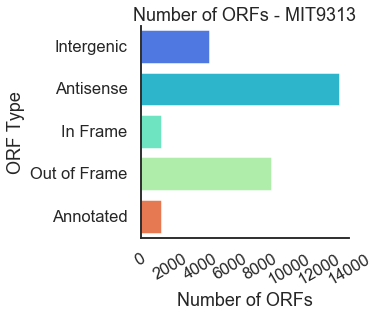

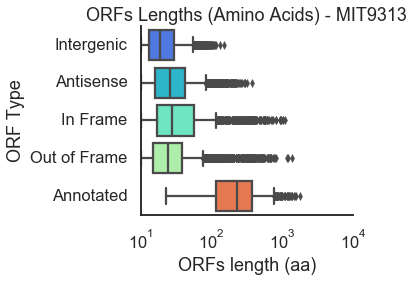

In [7]:
omap = {'standalone' : 'Intergenic', 
        'out_frame' : 'Out of Frame', 
        'antisense' : 'Antisense', 
        'in_frame' :'In Frame', 
        'known' : 'Annotated'}

genome = 'MIT9313'
df = pd.read_feather(os.path.join('orffinder_tmp', f'{genome}.ncbi.sorf.feather.gz'))
df = df.loc[df.otype != 'overlap']
df.otype = df.otype.map(omap)
    
sns.catplot(data=df, y='otype', kind='count', aspect=1.4, height=4,
       order=oorder, palette=opalette
           )
plt.xticks(rotation=30) 
plt.ylabel('ORF Type')
plt.xlabel('Number of ORFs')
plt.title(f'Number of ORFs - {genome}')

sns.catplot(data=df, y='otype', x='len_aa', aspect=1.4, height=4,
        kind='box',
       order=oorder, palette=opalette
           )
plt.xscale('log')
plt.ylabel('ORF Type')
plt.xlabel('ORFs length (aa)')

plt.title(f'ORFs Lengths (Amino Acids) - {genome}')
plt.show()
    

In [26]:
genome_df.head()

,contig_id,gene_id,pmt_id,type,location,strand,start,stop,left,right,function,genome,old_locus_tag,product,db_xref,protein_id,figfam,nucleotide_sequence,aa_sequence
0,MIT9313,AKG35_RS00005,PMT0001,CDS,AKG35_RS00005,+,173,1340,173,1340,DNA polymerase III subunit beta,MIT9313,"PMT0001,RG24_RS00005",DNA polymerase III subunit beta,GI:499441916,WP_011129380.1,,,MKLVCSQAELNTALQLVSRAVASRPTHPVLANVLLTADAGTDRLSL...
1,MIT9313,AKG35_RS00010,PMT0002,CDS,AKG35_RS00010,+,1343,2120,1343,2120,hypothetical protein,MIT9313,"PMT0002,RG24_RS00010",hypothetical protein,GI:752737102,WP_041384224.1,,,MNLPDQILLSDLLHHRVRCDQGLDHGPGVLPWMHPPVHRLLGWVSR...
2,MIT9313,AKG35_RS00015,PMT0003,CDS,AKG35_RS00015,+,2177,4562,2177,4562,phosphoribosylformylglycinamidine synthase sub...,MIT9313,"PMT0003,RG24_RS00015",phosphoribosylformylglycinamidine synthase sub...,GI:499441918,WP_011129382.1,,,MRVDYDVAAALRHEGLKPHDYDEICRRLQRAPNRVELGMFGVMWSE...
3,MIT9313,AKG35_RS00020,PMT0004,CDS,AKG35_RS00020,+,4621,6079,4621,6079,amidophosphoribosyltransferase,MIT9313,"PMT0004,RG24_RS00020",amidophosphoribosyltransferase,GI:499441919,WP_011129383.1,,,MCGIVGIVSTALVNQQIYDSLLLLQHRGQDSTGIATMDGSVFHLHK...
4,MIT9313,AKG35_RS00025,PMT0005,CDS,AKG35_RS00025,-,6114,8604,6114,8604,DNA topoisomerase 4 subunit A,MIT9313,"PMT0005,RG24_RS00025",DNA topoisomerase 4 subunit A,GI:499441920,WP_011129384.1,,,MAEERLQPIALHQEMQRSYLEYAMSVIVGRALPDARDGLKPVQRRI...


In [27]:
df.head()

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,...,overlap_strand,overlap_gene_type,overlap_count,is_same_strand,is_out_of_frame,is_inside,is_upstream,is_downstream,overlap_type,otype
0,ORF1_BX548175.1:78:176,BX548175.1,78,176,78,176,+,MNENDLPLHFLLACEILGDLFSVLVLVVTLIQ,99,32,...,+,CDS,1,1.0,1.0,0.0,1.0,0.0,upstream_out_frame,Out of Frame
1,ORF2_BX548175.1:453:590,BX548175.1,453,590,453,590,+,MRLVNRLNSKVQAGVIRCVGCLLMIFLNYLLLKVVRLSRLMRGLF,138,45,...,+,CDS,1,1.0,1.0,1.0,0.0,0.0,internal_out_frame,Out of Frame
2,ORF3_BX548175.1:669:722,BX548175.1,669,722,669,722,+,MVKPWKQRQLMVTALPF,54,17,...,+,CDS,1,1.0,1.0,1.0,0.0,0.0,internal_out_frame,Out of Frame
3,ORF4_BX548175.1:972:1025,BX548175.1,972,1025,972,1025,+,MVLLGVSMLIGVLLLQL,54,17,...,+,CDS,1,1.0,1.0,1.0,0.0,0.0,internal_out_frame,Out of Frame
4,ORF5_BX548175.1:1167:1205,BX548175.1,1167,1205,1167,1205,+,MLFRLLLMFVMY,39,12,...,+,CDS,1,1.0,1.0,1.0,0.0,0.0,internal_out_frame,Out of Frame


In [8]:
protein_df = pd.read_excel(protein_fpath, skiprows=1)

In [9]:
protein_df.head()

,Accession,Description,Score,Coverage,# Proteins,# Unique Peptides,# Peptides,# PSMs,Area,# AAs,MW [kDa],calc. pI,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,lcl,unnamed protein product - [ORF22701_BX548175.1...,264.49,74.73,1,9,9,66,7.47798e+10,91,9.82038,9.99365,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,A4,Sequence,# PSMs,# Proteins,# Protein Groups,Protein Group Accessions,Modifications,ΔCn,Area,q-Value,PEP,XCorr,Charge,MH+ [Da],ΔM [ppm],RT [min],# Missed Cleavages
2,NaN,High,TELTKTDVSLVVDAAIDTIIDSVVEGK,1,1,1,lcl,NaN,0,1.23224e+07,0,3.093e-16,8.84269,3,2831.51,-0.738287,232.912,1
3,NaN,High,TDVSLVVDAAIDTIIDSVVEGK,5,1,1,lcl,NaN,0,4.81268e+07,0,5.897e-15,7.60091,3,2259.19,-2.39155,233.944,0
4,NaN,High,TDVSLVVDAAIDTIIDSVVEGKK,2,1,1,lcl,NaN,0,6.16631e+07,0,5.524e-16,7.37785,3,2387.29,-2.2118,232.764,1


In [10]:
pdf = protein_df.dropna(subset=['Accession']).dropna(axis=1, how='all').reset_index(drop=True)

In [11]:
pdf.head()

,Accession,Description,Score,Coverage,# Proteins,# Unique Peptides,# Peptides,# PSMs,Area,# AAs,MW [kDa],calc. pI
0,lcl,unnamed protein product - [ORF22701_BX548175.1...,264.49,74.73,1,9,9,66,7.47798e+10,91,9.82038,9.99365
1,lcl,unnamed protein product - [ORF27991_BX548175.1...,780.223,94.95,1,6,6,129,62668485687,99,10.6449,4.09424
2,lcl,unnamed protein product - [ORF17148_BX548175.1...,438.661,72.82,1,9,9,100,6.19215e+10,103,10.8827,5.04639
3,lcl,unnamed protein product - [ORF8286_BX548175.1:...,374.565,58.82,1,9,9,73,56217832856,170,18.1622,4.94482
4,lcl,unnamed protein product - [ORF17149_BX548175.1...,4179.86,90.99,1,59,61,851,5.5555e+10,544,57.3609,5.0083


In [12]:
pdf['orfid'] = pdf['Description'].str.replace(r'unnamed protein product - \[', '').str.replace('\]$','')
pdf.head()

,Accession,Description,Score,Coverage,# Proteins,# Unique Peptides,# Peptides,# PSMs,Area,# AAs,MW [kDa],calc. pI,orfid
0,lcl,unnamed protein product - [ORF22701_BX548175.1...,264.49,74.73,1,9,9,66,7.47798e+10,91,9.82038,9.99365,ORF22701_BX548175.1:1481537:1481262
1,lcl,unnamed protein product - [ORF27991_BX548175.1...,780.223,94.95,1,6,6,129,62668485687,99,10.6449,4.09424,ORF27991_BX548175.1:1517947:1517648
2,lcl,unnamed protein product - [ORF17148_BX548175.1...,438.661,72.82,1,9,9,100,6.19215e+10,103,10.8827,5.04639,ORF17148_BX548175.1:1537470:1537159
3,lcl,unnamed protein product - [ORF8286_BX548175.1:...,374.565,58.82,1,9,9,73,56217832856,170,18.1622,4.94482,ORF8286_BX548175.1:1515352:1515864
4,lcl,unnamed protein product - [ORF17149_BX548175.1...,4179.86,90.99,1,59,61,851,5.5555e+10,544,57.3609,5.0083,ORF17149_BX548175.1:1537077:1535443


In [13]:
merge_df = pd.merge(df, pdf, how='left', on='orfid', suffixes=['','_p'])

In [14]:
merge_df.head()

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,...,Score,Coverage,# Proteins,# Unique Peptides,# Peptides,# PSMs,Area,# AAs,MW [kDa],calc. pI
0,ORF1_BX548175.1:78:176,BX548175.1,78,176,78,176,+,MNENDLPLHFLLACEILGDLFSVLVLVVTLIQ,99,32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ORF2_BX548175.1:453:590,BX548175.1,453,590,453,590,+,MRLVNRLNSKVQAGVIRCVGCLLMIFLNYLLLKVVRLSRLMRGLF,138,45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ORF3_BX548175.1:669:722,BX548175.1,669,722,669,722,+,MVKPWKQRQLMVTALPF,54,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ORF4_BX548175.1:972:1025,BX548175.1,972,1025,972,1025,+,MVLLGVSMLIGVLLLQL,54,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ORF5_BX548175.1:1167:1205,BX548175.1,1167,1205,1167,1205,+,MLFRLLLMFVMY,39,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
merge_df.rename(columns={
    '# Proteins': 'Proteins', 
    '# Unique Peptides':'Unique Peptides', 
    '# Peptides' : 'Peptides', 
    '# PSMs': 'PSMs',
    '# AAs' : 'AAs'
}, inplace=True)

In [16]:
merge_df['multiple unique peptides'] = merge_df['Unique Peptides'] > 1
merge_df['has unique peptides'] = merge_df['Unique Peptides'] > 0


In [17]:
merge_df['multiple unique peptides'].value_counts()

False    28620
True      1216
Name: multiple unique peptides, dtype: int64

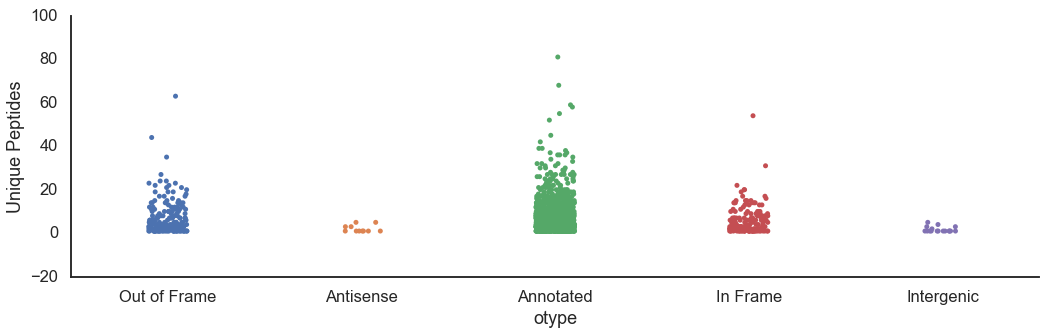

In [18]:
sns.catplot(data=merge_df, x='otype', y='Unique Peptides', aspect=3)

Text(0.5,1,'multiple unique peptides')

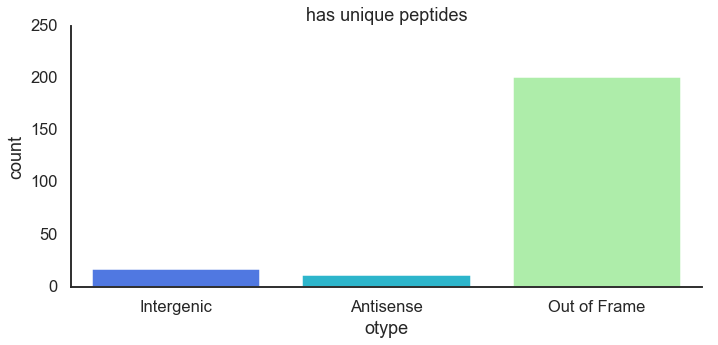

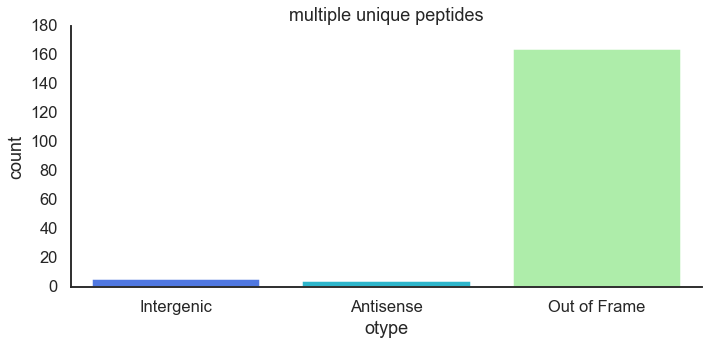

In [19]:
sns.catplot(data=merge_df.loc[merge_df['has unique peptides'] & ~merge_df.otype.isin(['Annotated', 'In Frame'])], 
            order=oorder[0:2] + [oorder[3]], palette=opalette[0:2] + [opalette[3]],
            x='otype', kind='count',  aspect=2)
plt.title('has unique peptides')
sns.catplot(data=merge_df.loc[merge_df['multiple unique peptides'] & ~merge_df.otype.isin(['Annotated', 'In Frame'])], 
            order=oorder[0:2] + [oorder[3]], palette=opalette[0:2] + [opalette[3]],
            x='otype', kind='count',  aspect=2)
plt.title('multiple unique peptides')


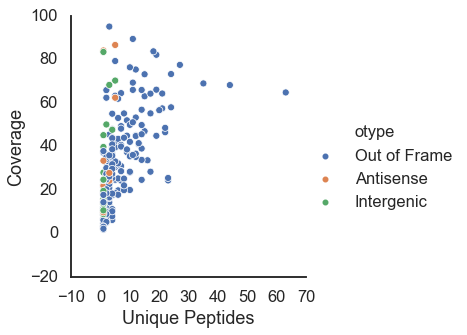

In [20]:
sns.relplot(data=merge_df.loc[merge_df['has unique peptides'] & ~merge_df.otype.isin(['Annotated', 'In Frame'])], 
            hue='otype', x='Unique Peptides', y='Coverage', s=50)


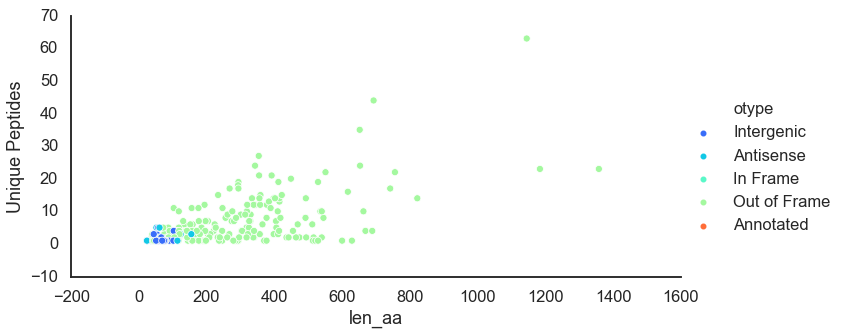

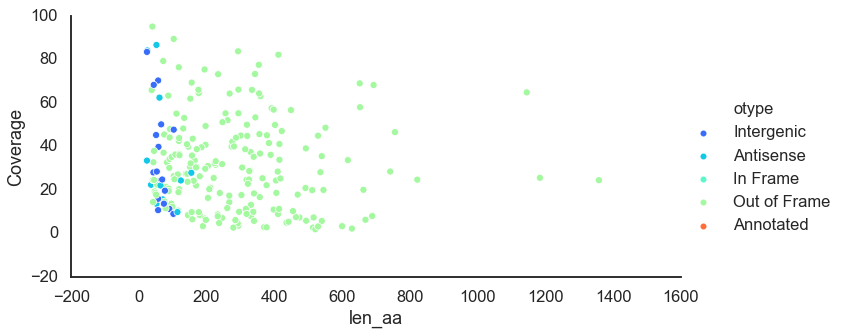

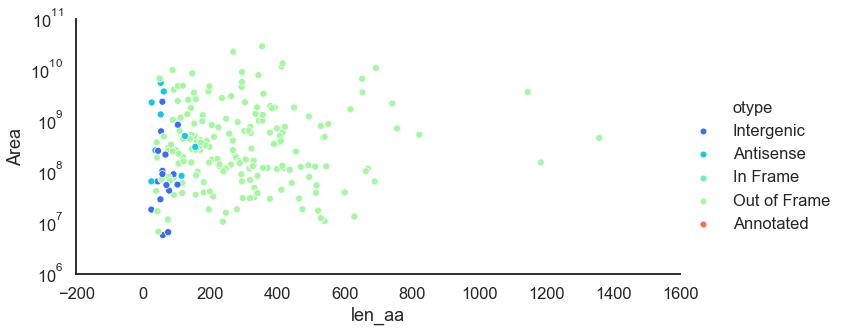

In [22]:
sns.relplot(data=merge_df.loc[merge_df['has unique peptides'] & ~merge_df.otype.isin(['Annotated', 'In Frame'])], 
            hue='otype', y='Unique Peptides', x='len_aa', s=50,
            hue_order=oorder, palette=opalette, aspect=2,
           )
sns.relplot(data=merge_df.loc[merge_df['has unique peptides'] & ~merge_df.otype.isin(['Annotated', 'In Frame'])], 
            hue='otype', y='Coverage', x='len_aa', s=50,
            hue_order=oorder, palette=opalette,aspect=2,
            
           )
sns.relplot(data=merge_df.loc[merge_df['has unique peptides'] & ~merge_df.otype.isin(['Annotated', 'In Frame'])], 
            hue='otype', y='Area', x='len_aa', s=50,
            hue_order=oorder, palette=opalette,aspect=2,
            
           )
plt.yscale('log')

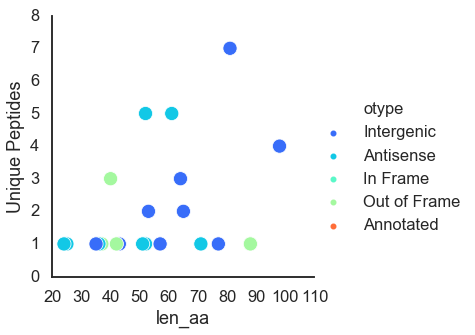

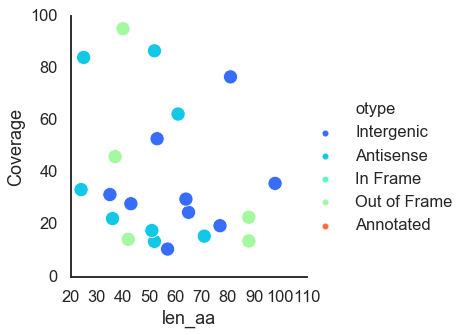

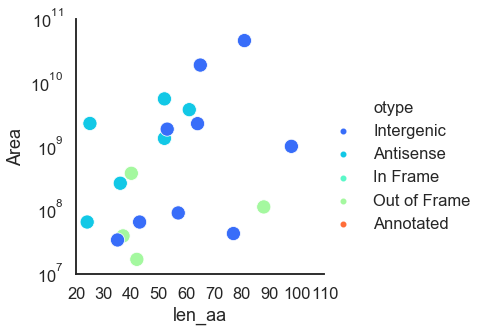

In [22]:
sns.relplot(data=merge_df.loc[merge_df['has unique peptides'] & ~merge_df.otype.isin(['Annotated', 'In Frame'])
                             & (merge_df.len_aa < 100)], 
            hue_order=oorder, palette=opalette,
            hue='otype', y='Unique Peptides', x='len_aa', s=200)
sns.relplot(data=merge_df.loc[merge_df['has unique peptides'] & ~merge_df.otype.isin(['Annotated', 'In Frame'])
                             & (merge_df.len_aa < 100)], 
            hue_order=oorder, palette=opalette,
            hue='otype', y='Coverage', x='len_aa', s=200)
sns.relplot(data=merge_df.loc[merge_df['has unique peptides'] & ~merge_df.otype.isin(['Annotated', 'In Frame'])
                             & (merge_df.len_aa < 100)], 
            hue_order=oorder, palette=opalette,
            hue='otype', y='Area', x='len_aa', s=200)
plt.yscale('log')

In [23]:
merge_df['Unique Peptides'] = pd.to_numeric(merge_df['Unique Peptides'])
merge_df['Coverage'] = pd.to_numeric(merge_df['Coverage'])


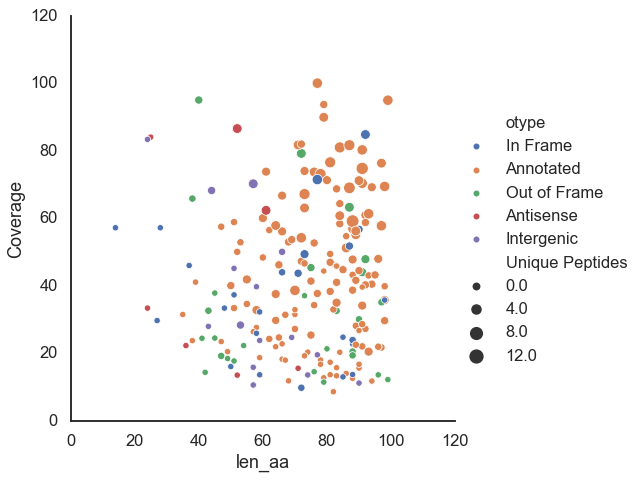

In [24]:
sns.relplot(data=merge_df.loc[merge_df['has unique peptides'] #& ~merge_df.otype.isin(['Annotated', 'In Frame'])
                             & (merge_df.len_aa < 100)], 
            #hue_order=oorder, palette=opalette,
            size='Unique Peptides',
            hue='otype', y='Coverage', x='len_aa', s=50,
            height=7,
           )


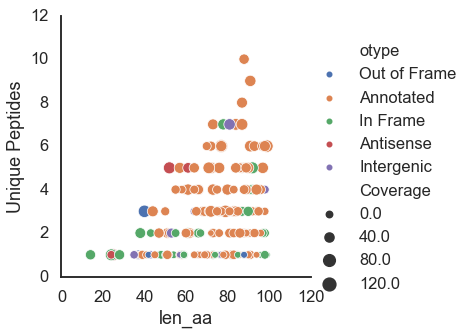

In [36]:
sns.relplot(data=merge_df.loc[merge_df['has unique peptides'] #& ~merge_df.otype.isin(['Annotated', 'In Frame'])
                             & (merge_df.len_aa < 100)], 
            #hue_order=oorder, palette=opalette,
            y='Unique Peptides',
            hue='otype', size='Coverage', x='len_aa', #s=50
           )


In [24]:
merge_df.loc[merge_df['has unique peptides'] & ~merge_df.otype.isin(['Annotated', 'In Frame'])]['Unique Peptides'].value_counts()

1     17
2      5
3      4
5      3
4      3
22     1
12     1
9      1
7      1
6      1
Name: Unique Peptides, dtype: int64

In [39]:
merge_df.columns

Index(['orfid', 'contig', 'left', 'right', 'start', 'stop', 'strand', 'aaseq',
       'len_nn', 'len_aa', 'len_aa3', 'rast_left', 'rast_right', 'contig_id',
       'gene_id', 'location', 'type', 'start_r', 'stop_r', 'function',
       'figfam', 'nucleotide_sequence', 'aa_sequence', 'genome', 'left_r',
       'right_r', 'is_downstream', 'is_inside', 'is_out_of_frame',
       'is_same_strand', 'is_upstream', 'otype', 'overlap_count',
       'overlap_gene_type', 'overlap_location', 'overlap_strand',
       'overlap_type', 'Accession', 'Description', 'Score', 'Coverage',
       'Proteins', 'Unique Peptides', 'Peptides', 'PSMs', 'Area', 'AAs',
       'MW [kDa]', 'calc. pI', 'multiple unique peptides',
       'has unique peptides'],
      dtype='object')

(0, 2600000)

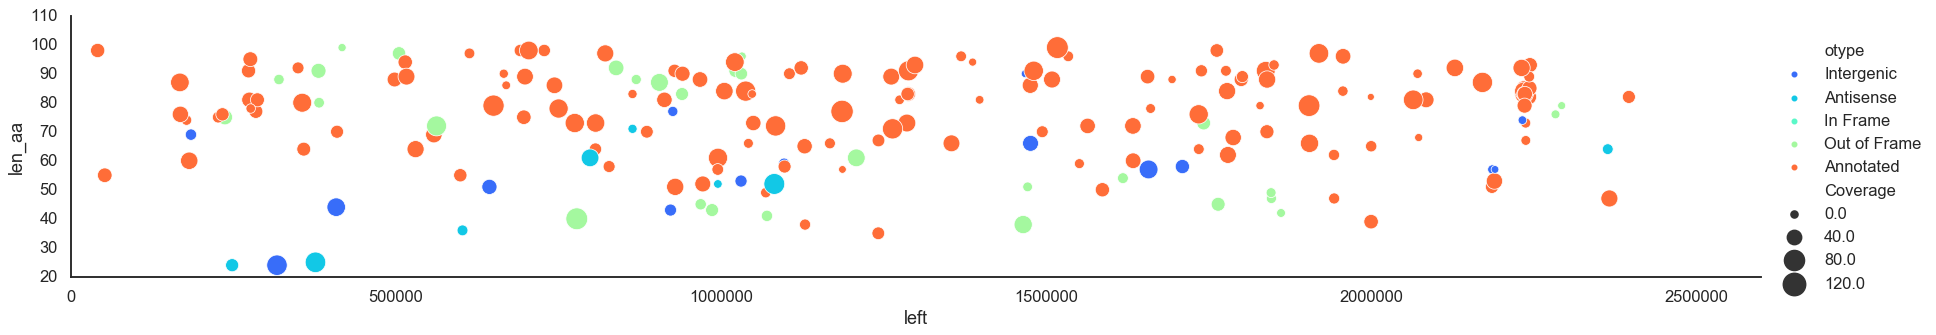

In [28]:
sns.relplot(data=merge_df.loc[merge_df['has unique peptides'] & ~merge_df.otype.isin(['In Frame'])
                             & (merge_df.len_aa < 100)], 
            hue_order=oorder, palette=opalette,
            #style='Unique Peptides',
            hue='otype', size='Coverage', y='len_aa', 
            x='left',
            sizes=(50,500),
            aspect=5,
            #markers=range(10)
           )
plt.xlim(0,2600000)

(0, 2600000)

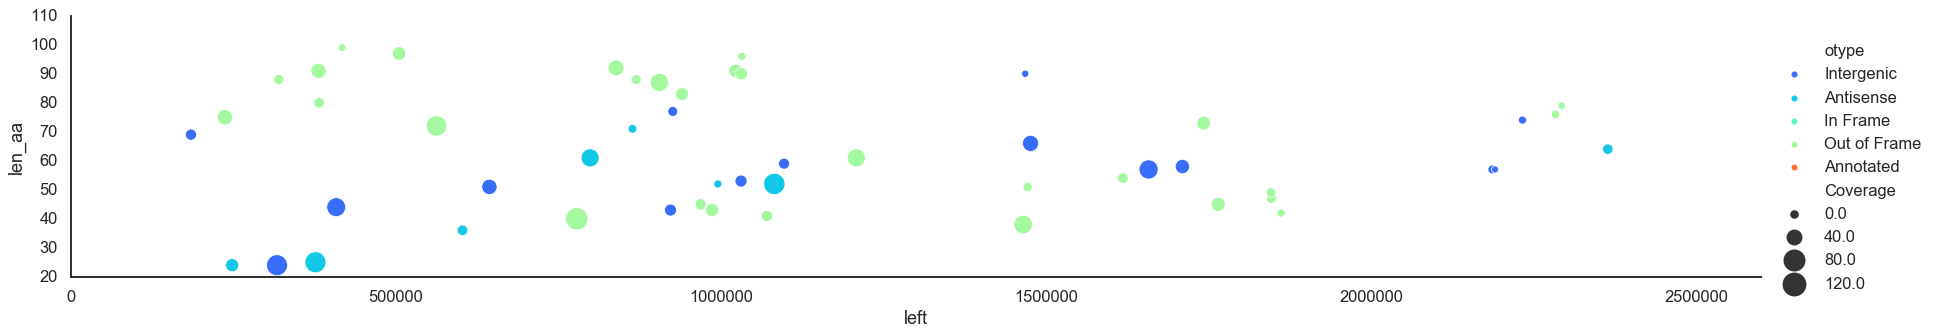

In [115]:
sns.relplot(data=merge_df.loc[merge_df['has unique peptides'] & ~merge_df.otype.isin(['Annotated', 'In Frame'])
                             & (merge_df.len_aa < 100)], 
            hue_order=oorder, palette=opalette,
            #y='Unique Peptides',
            hue='otype', size='Coverage', y='len_aa', 
            x='left',
            sizes=(50,500),
            aspect=5,
            
           )
plt.xlim(0,2600000)

(0, 2500000)

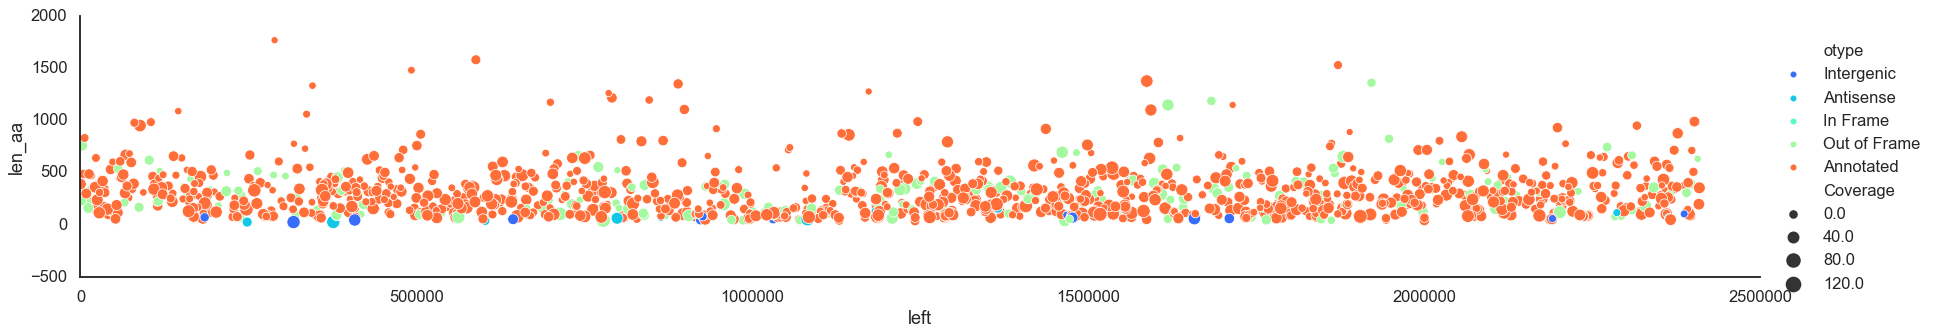

In [33]:
sns.relplot(data=merge_df.loc[merge_df['has unique peptides'] & ~merge_df.otype.isin(['In Frame'])
                         #    & (merge_df.len_aa < 100)
                             ], 
            hue_order=oorder, palette=opalette,
            #y='Unique Peptides',
            hue='otype', size='Coverage', y='len_aa', 
            x='left',
            sizes=(50,200),
            aspect=5,
            
           )
plt.xlim(0,2500000)

In [34]:
merge_df.otype.unique()

array(['Out of Frame', 'Antisense', 'Annotated', 'In Frame', 'Intergenic'],
      dtype=object)

Text(0.5,1,'protein found < 100 aa')

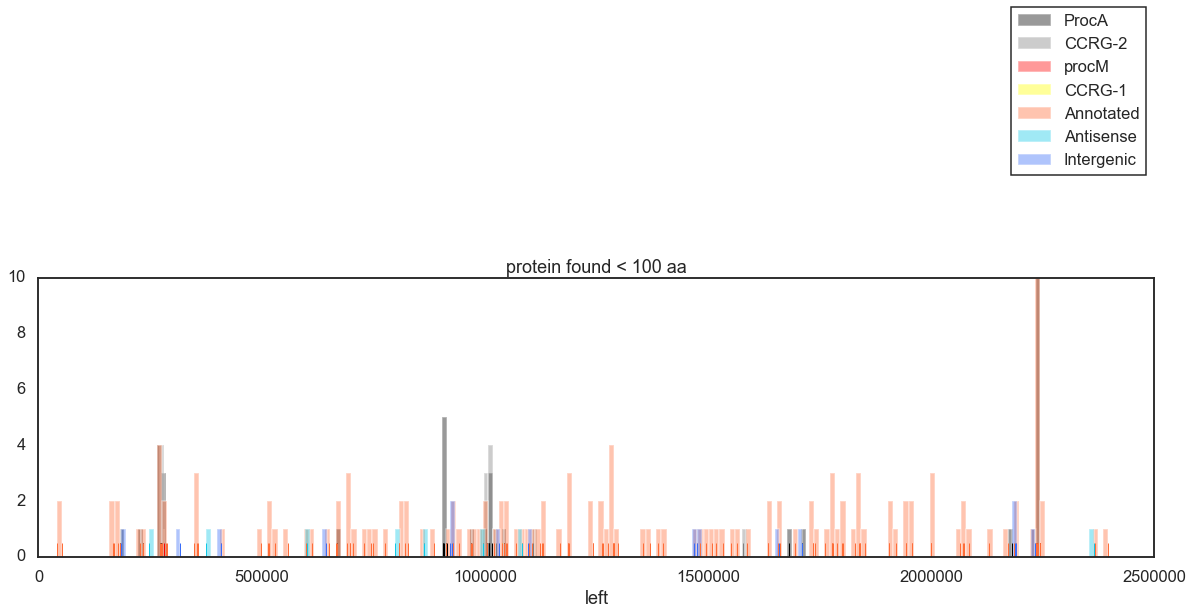

In [96]:
fig, ax = plt.subplots(figsize=(20,5))
for i,j in zip(['ProcA', 'CCRG-2', 'procM', 'CCRG-1'], ['black', 'grey', 'red', 'yellow']):
    sns.distplot(genome_df.loc[genome_df['family'].isin([i]),
                               'left'
                             ], 
             color=j,
                 bins=200,
             label=i, rug=True, kde=False, ax=ax
           )
for i in [ 'Annotated', 'Antisense', 
          #'In Frame', 'Out of Frame',
          'Intergenic']:
    sns.distplot(merge_df.loc[merge_df['has unique peptides'] & merge_df.otype.isin([i])
                         & (merge_df.len_aa < 100), 'left'
                             ], 
             color=opalette[oorder.index(i)],
                 bins=200,
             label=i, rug=True, kde=False, ax=ax
           )
    
plt.xlim(0,2500000)
plt.legend(bbox_to_anchor=(1,2))
plt.title('protein found < 100 aa')

(800000, 1100000)

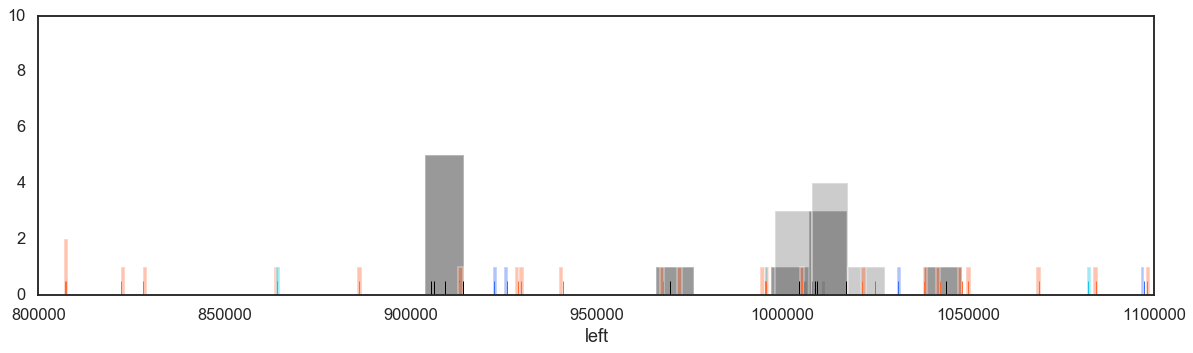

In [114]:
fig, ax = plt.subplots(figsize=(20,5))
for i,j in zip(['ProcA', 'CCRG-2', 'procM', 'CCRG-1'], ['black', 'grey', 'red', 'yellow']):
    sns.distplot(genome_df.loc[genome_df['family'].isin([i]),
                               'left'
                             ], 
             color=j,
                 bins=200,
             label=i, rug=True, kde=False, ax=ax
           )
for i in [ 'Annotated', 'Antisense', 
          #'In Frame', 'Out of Frame',
          'Intergenic']:
    sns.distplot(merge_df.loc[merge_df['has unique peptides'] & merge_df.otype.isin([i])
                         & (merge_df.len_aa < 100), 'left'
                             ], 
             color=opalette[oorder.index(i)],
                 bins=2000,
             label=i, rug=True, kde=False, ax=ax
           )
    
plt.xlim(800000,1100000)
#plt.legend(bbox_to_anchor=(1,2))
#plt.title('protein found < 100 aa')

(200000, 500000)

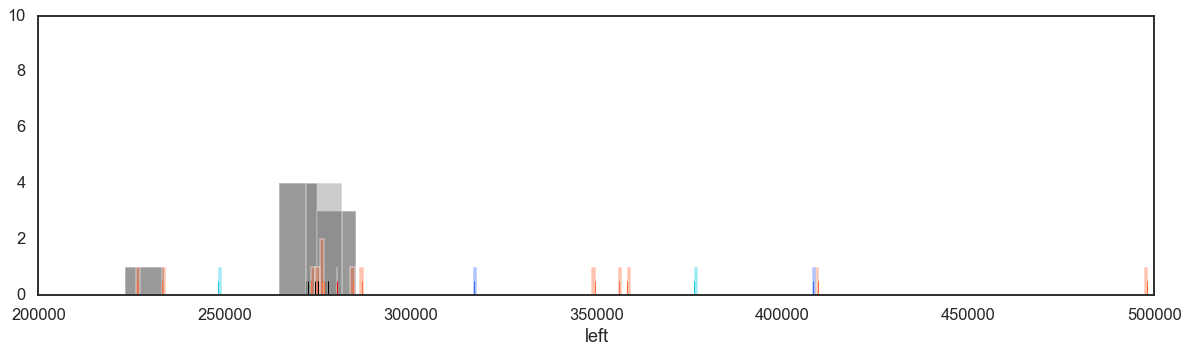

In [113]:
fig, ax = plt.subplots(figsize=(20,5))
for i,j in zip(['ProcA', 'CCRG-2', 'procM', 'CCRG-1'], ['black', 'grey', 'red', 'yellow']):
    sns.distplot(genome_df.loc[genome_df['family'].isin([i]),
                               'left'
                             ], 
             color=j,
                 bins=200,
             label=i, rug=True, kde=False, ax=ax
           )
for i in [ 'Annotated', 'Antisense', 
          #'In Frame', 'Out of Frame',
          'Intergenic']:
    sns.distplot(merge_df.loc[merge_df['has unique peptides'] & merge_df.otype.isin([i])
                         & (merge_df.len_aa < 100), 'left'
                             ], 
             color=opalette[oorder.index(i)],
                 bins=2000,
             label=i, rug=True, kde=False, ax=ax
           )
    
plt.xlim(200000,500000)
#plt.legend(bbox_to_anchor=(1,2))
#plt.title('protein found < 100 aa')

(2100000, 2300000)

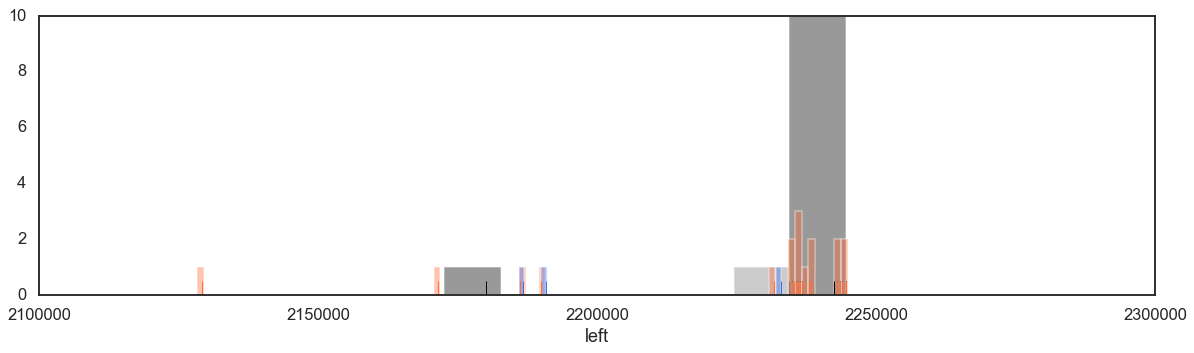

In [112]:
fig, ax = plt.subplots(figsize=(20,5))
for i,j in zip(['ProcA', 'CCRG-2', 'procM', 'CCRG-1'], ['black', 'grey', 'red', 'yellow']):
    sns.distplot(genome_df.loc[genome_df['family'].isin([i]),
                               'left'
                             ], 
             color=j,
                 bins=200,
             label=i, rug=True, kde=False, ax=ax
           )
for i in [ 'Annotated', 'Antisense', 
          #'In Frame', 'Out of Frame',
          'Intergenic']:
    sns.distplot(merge_df.loc[merge_df['has unique peptides'] & merge_df.otype.isin([i])
                         & (merge_df.len_aa < 100), 'left'
                             ], 
             color=opalette[oorder.index(i)],
                 bins=2000,
             label=i, rug=True, kde=False, ax=ax
           )
    
plt.xlim(2100000,2300000)
#plt.legend(bbox_to_anchor=(1,2))
#plt.title('protein found < 100 aa')

In [80]:
genome_df['family'].unique()

array([nan, 'ProcA', 'CCRG-2', 'procM', 'CCRG-1'], dtype=object)

(0, 2500000)

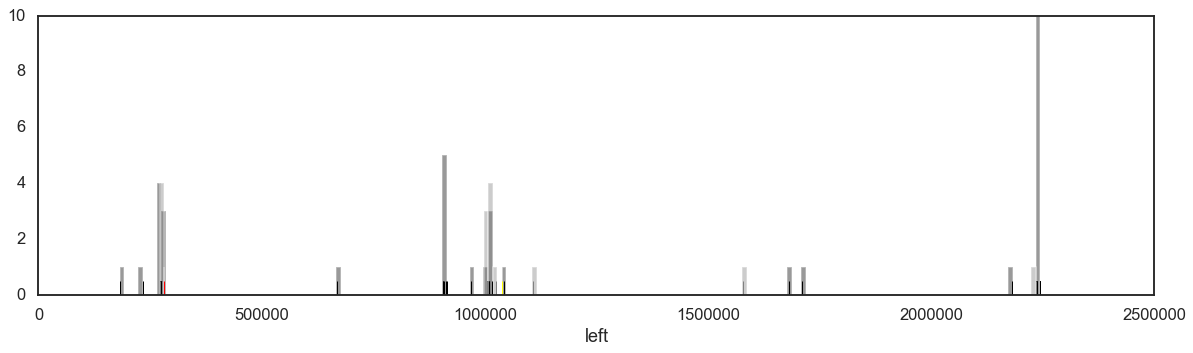

In [103]:
fig, ax = plt.subplots(figsize=(20,5))
for i,j in zip(['ProcA', 'CCRG-2', 'procM', 'CCRG-1'], ['black', 'grey', 'red', 'yellow']):
    sns.distplot(genome_df.loc[genome_df['family'].isin([i]),
                         #& (merge_df.len_aa < 100), 
                               'left'
                             ], 
             color=j,
                 bins=200,
             label=i, rug=True, kde=False, ax=ax
           )
plt.xlim(0,2500000)
#plt.legend()

In [31]:
genome_df.head()

,contig_id,gene_id,pmt_id,type,location,strand,start,stop,left,right,function,genome,old_locus_tag,product,db_xref,protein_id,figfam,nucleotide_sequence,aa_sequence
0,MIT9313,AKG35_RS00005,PMT0001,CDS,AKG35_RS00005,+,173,1340,173,1340,DNA polymerase III subunit beta,MIT9313,"PMT0001,RG24_RS00005",DNA polymerase III subunit beta,GI:499441916,WP_011129380.1,,,MKLVCSQAELNTALQLVSRAVASRPTHPVLANVLLTADAGTDRLSL...
1,MIT9313,AKG35_RS00010,PMT0002,CDS,AKG35_RS00010,+,1343,2120,1343,2120,hypothetical protein,MIT9313,"PMT0002,RG24_RS00010",hypothetical protein,GI:752737102,WP_041384224.1,,,MNLPDQILLSDLLHHRVRCDQGLDHGPGVLPWMHPPVHRLLGWVSR...
2,MIT9313,AKG35_RS00015,PMT0003,CDS,AKG35_RS00015,+,2177,4562,2177,4562,phosphoribosylformylglycinamidine synthase sub...,MIT9313,"PMT0003,RG24_RS00015",phosphoribosylformylglycinamidine synthase sub...,GI:499441918,WP_011129382.1,,,MRVDYDVAAALRHEGLKPHDYDEICRRLQRAPNRVELGMFGVMWSE...
3,MIT9313,AKG35_RS00020,PMT0004,CDS,AKG35_RS00020,+,4621,6079,4621,6079,amidophosphoribosyltransferase,MIT9313,"PMT0004,RG24_RS00020",amidophosphoribosyltransferase,GI:499441919,WP_011129383.1,,,MCGIVGIVSTALVNQQIYDSLLLLQHRGQDSTGIATMDGSVFHLHK...
4,MIT9313,AKG35_RS00025,PMT0005,CDS,AKG35_RS00025,-,6114,8604,6114,8604,DNA topoisomerase 4 subunit A,MIT9313,"PMT0005,RG24_RS00025",DNA topoisomerase 4 subunit A,GI:499441920,WP_011129384.1,,,MAEERLQPIALHQEMQRSYLEYAMSVIVGRALPDARDGLKPVQRRI...


In [101]:
df.head().T

,0,1,2,3,4
orfid,ORF1_BX548175.1:78:176,ORF2_BX548175.1:453:590,ORF3_BX548175.1:669:722,ORF4_BX548175.1:972:1025,ORF5_BX548175.1:1167:1205
contig,BX548175.1,BX548175.1,BX548175.1,BX548175.1,BX548175.1
left,78,453,669,972,1167
right,176,590,722,1025,1205
start,78,453,669,972,1167
stop,176,590,722,1025,1205
strand,+,+,+,+,+
aaseq,MNENDLPLHFLLACEILGDLFSVLVLVVTLIQ,MRLVNRLNSKVQAGVIRCVGCLLMIFLNYLLLKVVRLSRLMRGLF,MVKPWKQRQLMVTALPF,MVLLGVSMLIGVLLLQL,MLFRLLLMFVMY
len_nn,99,138,54,54,39
len_aa,32,45,17,17,12


In [102]:
genome_df.loc[genome_df.gene_id == 'AKG35_RS00005'].T

,0
contig_id,MIT9313
gene_id,AKG35_RS00005
pmt_id,PMT0001
type,CDS
location,AKG35_RS00005
strand,+
start,173
stop,1340
left,173
right,1340


In [129]:
merge_df.loc[merge_df['has unique peptides'] #& merge_df.otype.isin([i])
                         & (merge_df.len_aa < 100), 'otype'].value_counts()


Annotated       143
Out of Frame     29
In Frame         24
Intergenic       15
Antisense         8
Name: otype, dtype: int64

In [134]:

merge_df.loc[merge_df['has unique peptides'] #& merge_df.otype.isin([i])
                         & (merge_df.len_aa < 100), 'function'].value_counts().head(30)


hypothetical protein                                            61
Nif11-like leader peptide family natural product precursor      15
high light inducible protein                                     5
DUF4278 domain-containing protein                                2
2Fe-2S iron-sulfur cluster binding domain-containing protein     2
bacteriocin                                                      2
photosystem II reaction center protein J                         1
30S ribosomal protein S18                                        1
DUF2949 domain-containing protein                                1
DUF2839 domain-containing protein                                1
4a-hydroxytetrahydrobiopterin dehydratase                        1
Pr2TM family membrane protein                                    1
DUF3721 domain-containing protein                                1
DUF3188 domain-containing protein                                1
chlororespiratory reduction protein 7                         

In [140]:
merge_df.loc[merge_df['has unique peptides'] #& merge_df.otype.isin([i])
                         & (merge_df.len_aa < 100), 'function'].value_counts().tail(32)


30S ribosomal protein S17                        1
lantipeptide                                     1
cupin domain-containing protein                  1
carboxysome peptide B                            1
photosystem I iron-sulfur center protein PsaC    1
30S ribosomal protein S21                        1
rubredoxin                                       1
DUF751 family protein                            1
photosystem II reaction center protein PsbH      1
DUF1816 domain-containing protein                1
pterin-4-alpha-carbinolamine dehydratase         1
photosystem I reaction center subunit PsaK       1
50S ribosomal protein L33                        1
HU family DNA-binding protein                    1
NAD(P)H-quinone oxidoreductase subunit O         1
DUF2470 domain-containing protein                1
sulfur carrier protein ThiS                      1
guanylate-binding protein                        1
NifU family protein                              1
DUF3136 domain-containing prote